In [41]:
import os.path
import sys
import os
parent_dir = os.path.dirname(sys.path[0])
sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa
import bisect
import gym
import numpy as np
import random
import tensorflow as tf
from collections import deque
import networkx as nx
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import numpy as np
import random
from IPython.display import clear_output
from collections import deque

import gym

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [44]:
# the parametres
nombre_client  = 25
depot_c0j = CUSTOMER_DELIVERY_SERVICE_TIME + CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT/V_moy
 
 
STATE_SIZE = 6400
ACTION_SIZE = 3
LEARNING_RATE = 0.001
GAMMA = 0.99
BATCH_SIZE = 32
MEMORY_SIZE = 1000000
matrice_temps_Cij_shrinked = np.zeros((nombre_client+1 , nombre_client+1))
matrice_temps_Cij_shrinked[1: , 1:] = matrice_temps_Cij[:nombre_client,:nombre_client]

matrice_temps_Cij_shrinked[0,1:] = depot_c0j[:nombre_client]
matrice_temps_Cij_shrinked[1:,0] = depot_c0j[:nombre_client]

In [22]:
def get_matrice_adjacence(route):
     
    # Extraire tous les arcs de la route
    arcs_voiture = set()
    for sous_route in route:
        sous_route = [-1]+sous_route+[-1]
        arcs_voiture.update(set(zip(sous_route, sous_route[1:])))

    # Initialiser la matrice d'adjacence avec des zéros
    n = max(list(itertools.chain.from_iterable(route)))+2
    matrice_adj = [[0]*n for _ in range(n)]

    # Mettre à jour les valeurs correspondantes à chaque arc
    for i, j in arcs_voiture:
        matrice_adj[i+1][j+1] = 1
        #matrice_adj[i+1][j+1] = matrice_temps_Cij[i][j]

        
    output = np.array(matrice_adj)*matrice_temps_Cij_shrinked
    return (output-output.mean())/output.std()


In [24]:
get_matrice_adjacence([[1,2,3,5,8],[1,2,7]])

ValueError: operands could not be broadcast together with shapes (10,10) (26,26) 

In [4]:
def plot_routes(Solution, pos):
    arcs_voiture = set()
    for sous_route in Solution:
        sous_route = ["dp"]+sous_route+["dp"]
        arcs_voiture.update(set(zip(sous_route, sous_route[1:])))

    # Define the edges in the graph
    edges = arcs_voiture

    # Create a directed graph from the edge list
    G = nx.DiGraph(edges)


    nx.draw(G, pos, with_labels=True)
    plt.show()

In [7]:
# genere des solution aléatoire
def get_solution_random(nombre_client):
    list_client =  [i for i in range(nombre_client)]
    random.shuffle(list_client)
    solution = get_route(list_client,time_window,Q)
    return(solution)

## utiliser fonction cout pour calculer le cout d'une fonction

In [30]:
def get_voisinage(i,route):
    route_out = []
    if i==nombre_client-1:
        route_out =route
    else:
        G= list(itertools.chain.from_iterable(route))
        G[i],G[i+1] = G[i+1],G[i]
        route_out = get_route(G,time_window,Q)

    return route_out

In [29]:
Sol_init = get_solution_random(nombre_client)


In [31]:
import gym
from gym import spaces
import numpy as np
n = nombre_client + 1

class DQNEnv(gym.Env):
    """    """
    def __init__(self):
        
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,n*n))
        self.action_space = spaces.Discrete(nombre_client-1)
        self.state_routes = get_solution_random(nombre_client)
        self.state = np.array(get_matrice_adjacence(self.state_routes)).reshape(n*n,)
        self.num_iterations = 100
        self.done = False
        self.pos = {i: (random.random(), random.random()) for i in ["dp"]+[i for i in range(n)]}
        self.pos['dp'] = (0.5,0.5)

    def reset(self):

        self.state_routes = get_solution_random(nombre_client)
        self.state = np.array(get_matrice_adjacence(self.state_routes)).reshape(n*n,)
        self.done = False
        self.num_iterations = 100

        return self.state

    def step(self, action):
        
        #reward = cout(self.state_routes)
        new_route = get_voisinage(action, self.state_routes)
        self.num_iterations-=1
        #reward =reward - cout(self.state_routes)
        
        reward = cout(self.state_routes) - cout(new_route)
        self.state_routes = new_route
        self.state = np.array(get_matrice_adjacence(self.state_routes)).reshape(n*n,) # next state : 
        
        if self.num_iterations==0:
            self.done = True

        else:
            self.done = False

        return self.state, reward, self.done, {}
        
    def render(self):
        
        clear_output()
    
        plot_routes(self.state_routes, self.pos)
        
        time.sleep(0.1)
        
        
        
        

## deep q learning implimentation

In [32]:
import tensorflow as tf

# Define a lambda function to reshape the input tensor
reshape_func = lambda x: tf.reshape(x, shape=(1,nombre_client+1,nombre_client+1))

# Create a Lambda layer with the reshape function
reshape_layer = tf.keras.layers.Lambda(reshape_func)



In [33]:
class Agent:
    def __init__(self, enviroment, optimizer):
        
        # Initialize atributes
        #self._state_size = enviroment.observation_space.n
        self._action_size = nombre_client
        self._optimizer = optimizer
        self.enviroment = enviroment
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.1
        self.alpha = 0.1
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()
        

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):

        model = Sequential()
        model.add(Flatten(input_shape=(1,(nombre_client+1)*(nombre_client+1))))
        model.add(tf.keras.layers.Dense(10, activation='tanh'))
        model.add(Dense(nombre_client-1, activation='tanh'))
        
        model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=self._optimizer)
        return model

    def alighn_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(nombre_client-1)
        
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        states = np.zeros((batch_size,1,n*n))
        targets = np.zeros((batch_size,nombre_client-1))

        k = 0
        for state, action, reward, next_state, terminated in minibatch:
            #state = state.reshape(1,n*n)
            states[k] = state.reshape(1,n*n)
            
            if terminated:

                targets[k][action] = reward
                k = k+1

            else:
                t = self.target_network.predict(next_state)
                t_s = self.target_network.predict(state)
                targets[k][action] =t_s[0][action]+ self.alpha*(reward + self.gamma * (np.amax(t)-t_s[0][action]))
                k = k+1

        self.q_network.fit(states, targets, epochs=1, verbose=0) # backprop

    """
    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            state = state.reshape(1,1,101*101)
            target = self.q_network.predict(state)
            
            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(state, target, epochs=1, verbose=0)
            """

In [34]:
env = DQNEnv()
optimizer = Adam(learning_rate=0.01)
agent = Agent(env, optimizer)

batch_size = 32
num_of_episodes = 100
timesteps_per_episode = 1000
agent.q_network.summary()
optimizer = Adam(learning_rate=0.01)
agent = Agent(env, optimizer)

batch_size = 32
num_of_episodes = 100
timesteps_per_episode = 1000
agent.q_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 676)               0         
                                                                 
 dense (Dense)               (None, 10)                6770      
                                                                 
 dense_1 (Dense)             (None, 24)                264       
                                                                 
Total params: 7,034
Trainable params: 7,034
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 676)               0         
                                                                 
 dense_4 (Dense)             (No

## Training

In [16]:
## testing & debugage not for execute
batch_size = 16

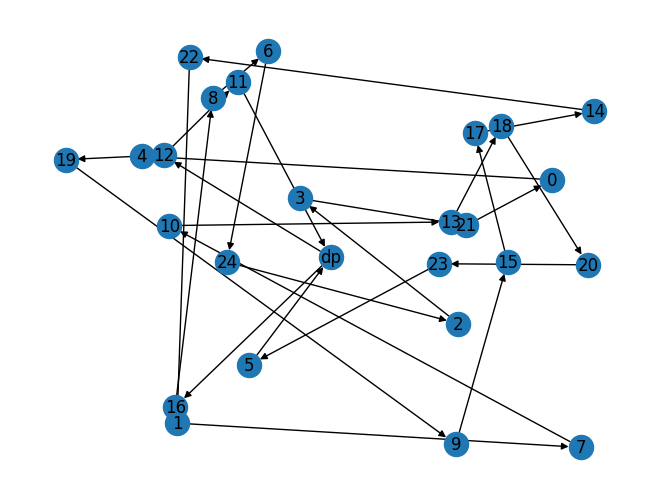

**********************************


In [15]:
num_of_episodes = 20
n = nombre_client+1
for e in range(0, num_of_episodes):
    # Reset the enviroment
    state = env.reset()
    state = state.reshape(1,1,n*n)
    
    # Initialize variables
    reward = 0
    terminated = False
    
    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=\
[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for timestep in range(timesteps_per_episode):
        # Run Action

        #if np.random.rand() < np.exp(-e):
            #action = agent.act(state)
        
        #else : 
        action = agent.act(state)
        
        # Take action    
        next_state, reward, terminated, info = env.step(action) 
        #next_state = np.reshape(next_state, [1, 1])
        next_state = next_state.reshape(1,1,n*n)
        agent.store(state, action, reward, next_state, terminated)
        
        env.state = next_state
        state = next_state
        
        if terminated:
            agent.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)
        
        if timestep%10 == 0:
            bar.update(timestep/10 + 1)
    
    bar.finish()
    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        env.render()
        print("**********************************")

### Importing and Testing the trainded model 

In [36]:
from tensorflow import keras
# Importing the model
agent.q_network = keras.models.load_model('agent_model.h5')

In [48]:
route = get_solution_random(nombre_client)

In [49]:
action = 0

## Comparaison de l'effécacité du Q_voisinnage avec le voisinnage classique

In [47]:
reward_ag = []
reward_rd = []

for i in range(100):
    route = get_solution_random(nombre_client)
    state = get_matrice_adjacence(route)
    lst = list(agent.q_network.predict(state.reshape(1,1,n*n))[0])
    #action1 = np.argmax(agent.q_network.predict(state.reshape(1,1,n*n)))
    action1 = lst.index(sorted(lst, reverse=True)[1]) 
    action2 = np.random.randint(nombre_client-1)
    new_route1 = get_voisinage(action1,route)
    new_route2 = get_voisinage(action2,route)

    reward_ag.append(cout(route)-cout(new_route1))
    reward_rd.append(cout(route)-cout(new_route2))

reward_ag = np.array(reward_ag)
reward_rd = np.array(reward_rd)

1/1 [==============================] - 0s 15ms/step


Text(0, 0.5, 'Exploration efficiency')

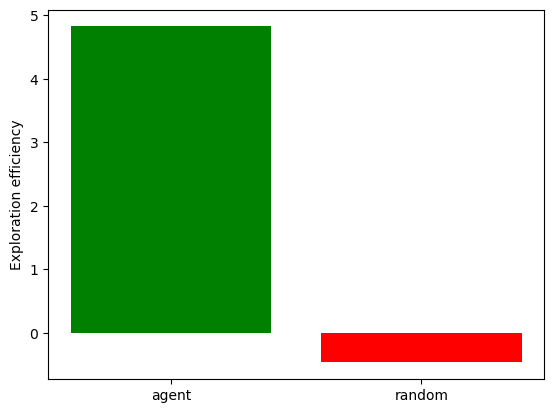

In [48]:
data1 = [reward_ag.mean()  , reward_rd.mean()]
categories = ['agent' , 'random']
plt.bar(categories , data1,color = ['green','red'])
plt.ylabel('Exploration efficiency')


## Optimization by Q learning

### Récuit simulé & Q learning

In [52]:

def Voisinnage(solution_route):
    solution = list(itertools.chain.from_iterable(solution_route))

    voisin = solution.copy()
    i = random.randint(0, len(solution) - 2)  # Sélection d'un élément au hasard
    j = random.randint(0, len(solution) - 2)
    voisin[i], voisin[j] = voisin[j], voisin[i]  # Échange des deux éléments
    return get_route(voisin,time_window, Q)


def Voisinnage_learned(solution_route,k):


    solution = list(itertools.chain.from_iterable(solution_route))
    voisin = solution.copy()

    route_matrix = get_matrice_adjacence(solution_route)
    q_values = list(agent.q_network.predict(route_matrix.reshape(1,1,n*n))[0])
    ##
    i = q_values.index(sorted(q_values, reverse=True)[k])
    j = random.randint(0, len(solution) - 1)
    voisin[i], voisin[j] = voisin[j], voisin[i]
    
    return get_route(voisin,time_window, Q)


def recuit_simule_learned(initial_state,  temperature_initiale=1.0, temperature_finale=1e-8, alpha=0.99):
    """
    Implémente l'algorithme de recuit simulé pour résoudre le problème de VRP.
    """
    
    current_state = initial_state
    current_energy = cout(current_state)
    best_state = current_state
    best_energy = current_energy
    temperature = temperature_initiale
    # Calculer le paramètre beta pour la loi de Boltzmann
    beta = abs(1/ (5 * math.log(0.66)))

    history_sol=[]
    history = []
    actions = []
    count = 0

    while temperature > temperature_finale:
        # Générer une nouvelle solution voisine
        new_state  =  Voisinnage_learned(current_state.copy(),count)
        count = (count+1)%20
        new_energy = cout(new_state)
        delta_energy = new_energy - current_energy
        # Accepter ou non la nouvelle solution
        if delta_energy < 0 or math.exp(-1 / (beta*temperature)) >random.random():
            current_state = new_state
            current_energy = new_energy

        # Mettre à jour la meilleure solution trouvée jusqu'à présent
         
        best_state = current_state
        best_energy = current_energy

        temperature *= alpha
        history.append(best_energy)
        history_sol.append(best_state)

    # Retourner la meilleure solution trouvée
    indice = history.index(min(history))
    return history_sol[indice] , history[indice],history
     


def recuit_simule(initial_state,  temperature_initiale=1.0, temperature_finale=1e-8, alpha=0.99):
    """
    Implémente l'algorithme de recuit simulé pour résoudre le problème de VRP.
    """
    
    current_state = initial_state
    current_energy = cout(current_state)
    best_state = current_state
    best_energy = current_energy
    temperature = temperature_initiale
    # Calculer le paramètre beta pour la loi de Boltzmann
    beta = abs(1/ (5 * math.log(0.66)))

    history_sol=[]
    history = []
    while temperature > temperature_finale:
        # Générer une nouvelle solution voisine
        new_state =  Voisinnage(current_state.copy())
        new_energy = cout(new_state)
        delta_energy = new_energy - current_energy
        # Accepter ou non la nouvelle solution
        if delta_energy < 0 or math.exp(-1 / (beta*temperature)) >random.random():
            current_state = new_state
            current_energy = new_energy

        # Mettre à jour la meilleure solution trouvée jusqu'à présent
         
        best_state = current_state
        best_energy = current_energy

        temperature *= alpha
        history.append(best_energy)
        history_sol.append(best_state)

    # Retourner la meilleure solution trouvée
    indice = history.index(min(history))
    return history_sol[indice] , history[indice],history

In [54]:
Sol_init = get_solution_random(nombre_client)
best_state, best_energy , history_t_1 = recuit_simule_learned(Sol_init,  temperature_initiale=1.0, temperature_finale=1e-9, alpha=0.99)
best_state_2, best_energy_2 , history_t_2 = recuit_simule(Sol_init,  temperature_initiale=1.0, temperature_finale=1e-9, alpha=0.99)

1/1 [==============================] - 0s 23ms/step


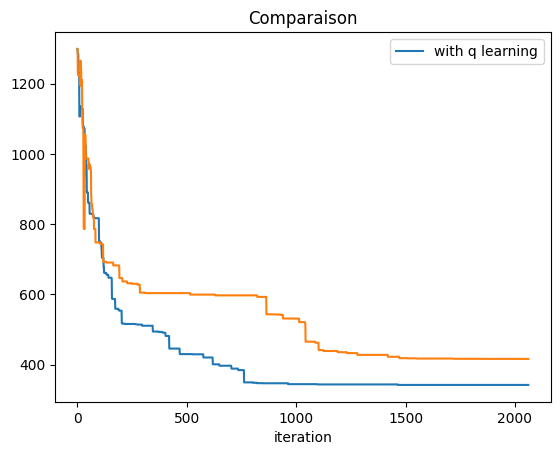

In [222]:
plt.plot(history_t_1, label = 'with q learning')
plt.plot(history_t_2)
plt.legend()
plt.xlabel('iteration')
plt.title('Comparaison')
plt.savefig('Résultats/dqn_recuit.jpg')

In [229]:
import random

# Définition de la fonction de voisinage
def voisinage(solution_route):

    solution = list(itertools.chain.from_iterable(solution_route))
    voisin = solution.copy()
    i = random.randint(0, len(solution) - 1)  # Sélection d'un élément au hasard
    j = random.randint(0, len(solution) - 1)  # Sélection d'un autre élément au hasard
    voisin[i], voisin[j] = voisin[j], voisin[i]  # Échange des deux éléments

    return get_route(voisin,time_window, Q)



def Voisinnage_learned(solution_route,k):


    solution = list(itertools.chain.from_iterable(solution_route))
    voisin = solution.copy()

    route_matrix = get_matrice_adjacence(solution_route)
    q_values = list(agent.q_network.predict(route_matrix.reshape(1,1,n*n))[0])
    ##
    i = q_values.index(sorted(q_values, reverse=True)[k])
    j = random.randint(0, len(solution) - 1)
    voisin[i], voisin[j] = voisin[j], voisin[i]
    
    return get_route(voisin,time_window, Q)
# Définition de l'algorithme Tabou
def tabou_learned(liste_initiale, taille_tabou, max_iterations,n_voisin):
    
     
    meilleure_solution = liste_initiale # la meilleure solution trouvée jusqu'à présent
    meilleure_valeur = cout(meilleure_solution) # la valeur de la meilleure solution
    history_sol=[meilleure_solution]
    liste_tabou = [] # la liste tabou pour stocker les solutions interdites
    history = [meilleure_valeur] # tableau qui stocke la meilleure valeur de chaque itération
    count = 0
    
    for i in range(max_iterations):
        
        # recherche du meilleur voisin parmi les n_voisin voisins générés
        for i in range(n_voisin):
            voisin = Voisinnage_learned(meilleure_solution,count)
            count = (count+1)%20
            # Si le voisin est dans la liste tabou, on en génère un autre
            while voisin in liste_tabou:
                voisin = Voisinnage_learned(meilleure_solution,count)
                count = (count+1)%20

            if i==0:
                # si c'est le premier voisin, on initialise la meilleure valeur avec celle-ci
                valeur_meilleur_voisin = cout(voisin)
                meilleur_voisin = voisin
                 
            else:
                # sinon, on compare avec la valeur du voisin précédent
                s = cout(voisin)
                if s<valeur_meilleur_voisin:
                    meilleur_voisin = voisin
                    valeur_meilleur_voisin = s
            
        # on passe au meilleur voisin trouvé de la solution courante
        meilleure_solution = meilleur_voisin
        meilleure_valeur = valeur_meilleur_voisin
            
        # ajout de la solution courante à la liste tabou
        liste_tabou.append(meilleure_solution)
        
        # Si la taille de la liste tabou dépasse la taille maximale autorisée, on supprime le premier élément
        if len(liste_tabou) > taille_tabou:
            liste_tabou.pop(0)
            
        # ajout de la meilleure valeur à l'historique
        history.append(meilleure_valeur)
        history_sol.append(meilleure_solution)

    # retourne la meilleure solution trouvée, sa valeur et l'historique des meilleures valeurs
    indice = history.index(min(history))
    return history_sol[indice] , history[indice] , history


# Définition de l'algorithme Tabou
def tabou(liste_initiale, taille_tabou, max_iterations,n_voisin):
    
     
    meilleure_solution = liste_initiale # la meilleure solution trouvée jusqu'à présent
    meilleure_valeur = cout(meilleure_solution) # la valeur de la meilleure solution
    history_sol=[meilleure_solution]
    liste_tabou = [] # la liste tabou pour stocker les solutions interdites
    history = [meilleure_valeur] # tableau qui stocke la meilleure valeur de chaque itération

    
    for i in range(max_iterations):
        
        # recherche du meilleur voisin parmi les n_voisin voisins générés
        for i in range(n_voisin):
            voisin = voisinage(meilleure_solution)
            
            # Si le voisin est dans la liste tabou, on en génère un autre
            while voisin in liste_tabou:
                voisin = voisinage(meilleure_solution)
                

            if i==0:
                # si c'est le premier voisin, on initialise la meilleure valeur avec celle-ci
                valeur_meilleur_voisin = cout(voisin)
                meilleur_voisin = voisin
                 
            else:
                # sinon, on compare avec la valeur du voisin précédent
                s = cout(voisin)
                if s<valeur_meilleur_voisin:
                    meilleur_voisin = voisin
                    valeur_meilleur_voisin = s
            
        # on passe au meilleur voisin trouvé de la solution courante
        meilleure_solution = meilleur_voisin
        meilleure_valeur = valeur_meilleur_voisin
            
        # ajout de la solution courante à la liste tabou
        liste_tabou.append(meilleure_solution)
        
        # Si la taille de la liste tabou dépasse la taille maximale autorisée, on supprime le premier élément
        if len(liste_tabou) > taille_tabou:
            liste_tabou.pop(0)
            
        # ajout de la meilleure valeur à l'historique
        history.append(meilleure_valeur)
        history_sol.append(meilleure_solution)

    # retourne la meilleure solution trouvée, sa valeur et l'historique des meilleures valeurs
    indice = history.index(min(history))
    return history_sol[indice] , history[indice] , history


In [233]:
list_client_initial = get_route([i for i in range(nombre_client)],time_window, Q) 
taille_tabou = 20
max_iterations = 200
taille_voisin = 10

meilleure_solution, meilleure_valeur , history_2 = tabou_learned(list_client_initial, taille_tabou, max_iterations,7)
meilleure_solution, meilleure_valeur , history_1 = tabou(list_client_initial, taille_tabou, max_iterations,7)

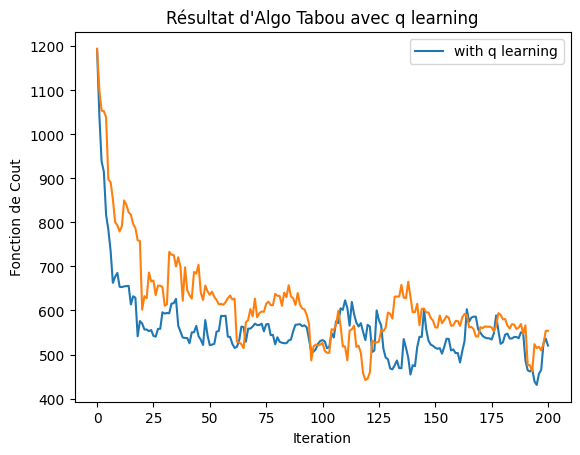

In [238]:
plt.plot(history_2 , label = 'with q learning')
plt.plot(history_1 )
plt.xlabel('Iteration')
plt.ylabel('Fonction de Cout')
plt.title("Résultat d'Algo Tabou avec q learning")
plt.legend()
plt.savefig('Résultats/q_learning_tabou3.jpg')